# Quantum Generative Adversarial Network (QGAN)

This tutorial demonstrates how to use the `QGAN` class from Quple. It implements the basic architecture of a Generative Adversarial Network (GAN) equipped with generator and discriminator networks in both classical and quantum settings.

# Introduction

## Basic Principles of GAN

A Generative Adversarial Network (GAN) consists of two neural networks: a **generator** and a \btext{discriminator} (or critic) which compete with together in a minimax two-player game.

The goal for the generator is to generate new data (the **fake data**) that **resembles** the given training data (the **real data**) as closely as possible. This training data can be images, text, audio or any kind of numerical data. The goal for the discriminator on the other hand is to distinguish fake data samples created by the generator from the real data samples.

The generator $\mathcal{G}$ takes as input the prior samples $z$ from a prior distribution $q$ and outputs a fake data $\mathbf{x}_{g} = (\mathbf{z})$ where $G$ denotes the transformation (i.e. the neural net) made by $\mathcal{G}$. The prior of $\mathcal{G}$ is conventionally a high-dimensional continuous normal distribution with zero mean and unit variance. 

The discriminator $\mathcal{D}$ takes indenpently as inputs the real data $\mathbf{x}$ and the fake data $G(\mathbf{z})$ and outputs the values $D(\mathbf{x})$ and $D(G(\mathbf{z}))$ where $D$ denotes the transformation made by $\mathcal{D}$.

In the original GAN paper by [Goodfellow](https://arxiv.org/pdf/1406.2661.pdf), the method is applied to generate fake images  which uses deep convolution architectures in the generator and discriminator neural networks. The generator and discriminator are trained according to the adversarial **minimax loss function**

$$\min_G\max_D L(D, G) = \mathbb{E}_{x\sim p_{r}(x)}[\log D(x)] + \mathbb{E}_{z\sim q(z)} [\log(1-D(G(z)))]$$
$$ = \mathbb{E}_{x\sim p_{r}(x)}[\log D(x)] + \mathbb{E}_{x\sim p_{g}(x)} [\log(1-D(x))]$$

where $p_{r}(x)$ is the data distribution over real sample $x$, $p_{g}(x)$ is the generator's distribution over data $x$.

### Some remarks on the loss function - 1

This loss function quantifies the similarity between the generative data distribution $p_{g}(x)$ and the real sample distribution $p_{r}(x)$ by the Jensen-Shannon divergence divergence when the discriminator is optimal:

$$L(G,D^∗)=2JS(p_{r}||p_{g})−2log2$$

where $D^*$ represents the optimal discriminator that maximizes the loss function, and $JS$ is the Jensen-Shannon divergence, i.e.

$$ JS(p||q) = KL(p|| \frac{p+q}{2}) + KL(q||\frac{p+q}{2})$$

where $KL$ is the Kullback-Leiber divergence.

#### Some remarks on the loss function - 2

The minimax loss function can cause the GAN to get stuck in the early stages of GAN training when the discriminator's job is too easy. The original paper suggested modifying the generator loss so that the generator tries to maximize $log D(G(z))$ instead

## Basic principles of a Quantum GAN (QGAN)

The essence of a quantum version of the Generative Adversarial Network (GAN) is to replace the generator and discriminator neural networks with quantum neural networks made up of parameterized quantum circuits (PQCs).

Both quantum generator and discriminator neural networks consist of two key components. The first component is a data encoding circuit (i.e. the **input layer**) that maps classical input data $x\in \mathbb{R}^N$  of $N$ variables into a quantum state $|\Phi(x)\rangle = U_{\Phi(x)}|0\rangle^N$ using a quantum feature map (Ref [Temme](https://www.nature.com/articles/s41586-019-0980-2)) $\Phi(\mathbf{x})$. The quantum state is then passed to a PQC layer (represented by the circuit ($W(\theta)$) made up of a series of parameterized local single-qubit rotations $U_{\text{loc}}(\boldsymbol{\theta})$ and two-qubit entagling operations in which the circuit parameters represent the weights of a neural network. 

A pure quantum neural network therefore represents the combined circuit operation  $W(\boldsymbol{\theta}) | \Phi(\mathbf{x})\rangle$.

Finally a total of $R$ (repetitions) of measurements (via a measurement operator $M_i$ which usually is the Pauli $Z$ operator acting on the $i$-th qubit) is made on one or multiple qubits of the combined circuit to measure the expectation values $P_i(\mathbf{x}) = \langle \Phi(\mathbf{x}) | W(\theta)^\dagger M_i W(\boldsymbol{\theta})|\Phi(\mathbf{x})\rangle$. 


## Implementation of the `QGAN` class

- Similar to the classical case, the quantum generator would take as input $\mathbf{z}$ which would be standard Gaussian distributed random variables of a certain dimension (called `latent_dim`) specified by the user.

- The quantum generator and discriminator neural networks normally consist of multiple layers of `PQC` and/or `QConv2D` instances from Quple which inherit from the tensorflow Keras Layer API.

- By default the `QGAN` class uses the binary cross-entropy loss function which is the same as the modified minimax loss function

- A classical optimizer such as Adam will be used to tune the circuit parameters $\boldsymbol{\theta}_G$ and $\boldsymbol{\theta}_D$ in the quantum generator and discriminator.

To better illustrates how the `QGAN` class works and the various features supported by the `QGAN` class, we will create a simple test case for demonstration.

## 0. Setup

In [1]:
import sys
# install modules if inside google Colab environment
if 'google.colab' in sys.modules:
    !pip install tensorflow==2.4.1
    !pip install tensorflow-quantum
    !pip install quple==0.9.0

In [2]:
import numpy as np

import tensorflow as tf
import tensorflow_quantum as tfq

from quple.utils.visualization import visualize_images
from quple.data_encoding import FirstOrderPauliZEncoding
from quple import ParameterisedCircuit

from quple.interface.tfq.layers import PQC, QConv2D
from quple.utils.data_preparation import rescale_data

## 1. Create test images

- We will reuse the test images from the last tutorial (T10) on the `QConv2D` layer. They are two classes of 4x4 images:

1. Dark pixels in the central 2x2 region and the four corners;
2. Bright pixels in the central 2x2 region and the four corners (i.e. inverse of 1.)

- This time our goal is to train a QGAN model to generate these test images instead of classifying them.

In [3]:
# set random seed for reproducibility
np.random.seed(2021)

sample_size = 1000
x_class_1 = np.random.normal(1, 0.1, size=(sample_size, 4, 4))
x_class_2 = np.random.normal(1, 0.1, size=(sample_size, 4, 4))
mesh_1 = np.array([[0, 1, 1, 0],
                   [1, 0, 0, 1],
                   [1, 0, 0, 1],
                   [0, 1, 1, 0]])
mesh_2 = np.array([[1, 0, 0, 1],
                   [0, 1, 1, 0],
                   [0, 1, 1, 0],
                   [1, 0, 0, 1]])
x_class_1 = x_class_1 - mesh_1
x_class_2 = x_class_2 - mesh_2

# rescale the data to have pixel value between 0 and 1
x_class_1 = rescale_data(x_class_1, val_range=(0, 1))
x_class_2 = rescale_data(x_class_2, val_range=(0, 1))

Let's take a look at the two classes of images

Image class 1:


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

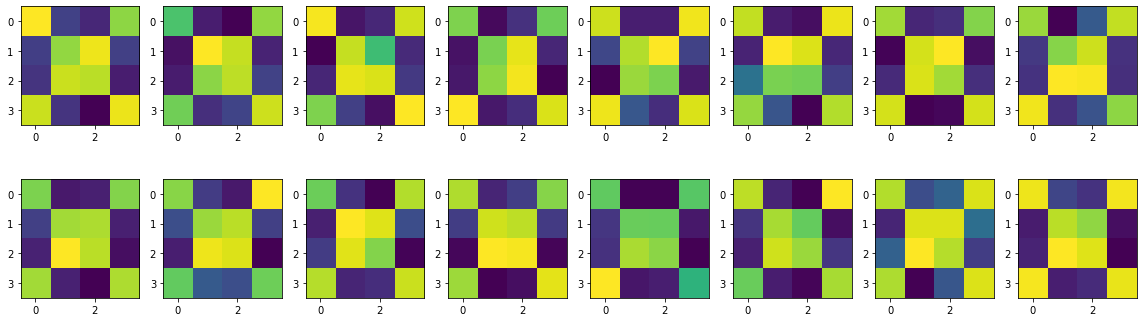

In [4]:
print("Image class 1:")
visualize_images(x_class_1[:16])

Image class 2:


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

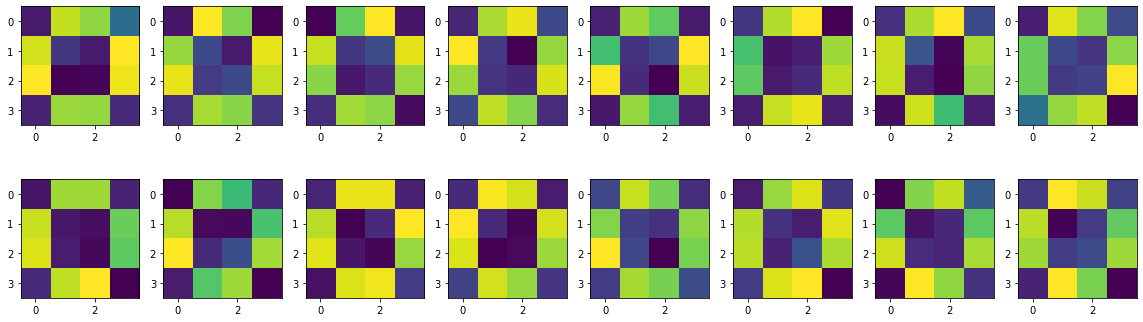

In [5]:
print("Image class 2:")
visualize_images(x_class_2[:16])

## 2. Construct Quantum Generator and Discriminator Neural Networks

- We will use both the `QConv2D` layer and the `PQC` layer to construct our quantum generator and quantum discriminator neural networks

### Quantum Filters

- We will use both 2x2 and 3x3 quantum filters for the `QConv2D` layer

The **data encoding circuits** for the quantum filters consist of a layer of **Hadamard gates** and a layer of **Rz rotation** with rotation angles parameterized by the pixel values of the input data patches. The two layers are **repeated 2 times**. 

In [6]:
data_circuit_2x2 = FirstOrderPauliZEncoding(feature_dimension=4, copies=2, parameter_scale=1)
data_circuit_2x2

(0, 0): ───H───Rz(pi*<x_0/pi>)───H───Rz(pi*<x_0/pi>)───

(0, 1): ───H───Rz(pi*<x_1/pi>)───H───Rz(pi*<x_1/pi>)───

(0, 2): ───H───Rz(pi*<x_2/pi>)───H───Rz(pi*<x_2/pi>)───

(0, 3): ───H───Rz(pi*<x_3/pi>)───H───Rz(pi*<x_3/pi>)───

In [7]:
data_circuit_3x3 = FirstOrderPauliZEncoding(feature_dimension=9, copies=2, parameter_scale=1)
data_circuit_3x3

(0, 0): ───H───Rz(pi*<x_0/pi>)───H───Rz(pi*<x_0/pi>)───

(0, 1): ───H───Rz(pi*<x_1/pi>)───H───Rz(pi*<x_1/pi>)───

(0, 2): ───H───Rz(pi*<x_2/pi>)───H───Rz(pi*<x_2/pi>)───

(0, 3): ───H───Rz(pi*<x_3/pi>)───H───Rz(pi*<x_3/pi>)───

(0, 4): ───H───Rz(pi*<x_4/pi>)───H───Rz(pi*<x_4/pi>)───

(0, 5): ───H───Rz(pi*<x_5/pi>)───H───Rz(pi*<x_5/pi>)───

(0, 6): ───H───Rz(pi*<x_6/pi>)───H───Rz(pi*<x_6/pi>)───

(0, 7): ───H───Rz(pi*<x_7/pi>)───H───Rz(pi*<x_7/pi>)───

(0, 8): ───H───Rz(pi*<x_8/pi>)───H───Rz(pi*<x_8/pi>)───

The **kernel circuits** consist of a layer of **Ry and Rz rotations** parameterized by the neural network weights $\theta$ followed by a layer of **CNOT gates for entanglement** with **linear nearest-neighbor connectivity** arranged in an "alternate" manner. 

In [8]:
kernel_circuit_2x2 = ParameterisedCircuit(n_qubit=4, copies=2, 
                                      rotation_blocks=["RY", "RZ"],
                                      entanglement_blocks=["CX"],
                                      entangle_strategy="alternate_linear")
kernel_circuit_2x2

(0, 0): ───Ry(θ_0)───Rz(θ_4)───@───Ry(θ_8)───Rz(θ_12)──────────────@───────
                               │                                   │
(0, 1): ───Ry(θ_1)───Rz(θ_5)───X───@─────────Ry(θ_9)────Rz(θ_13)───X───@───
                                   │                                   │
(0, 2): ───Ry(θ_2)───Rz(θ_6)───@───X─────────Ry(θ_10)───Rz(θ_14)───@───X───
                               │                                   │
(0, 3): ───Ry(θ_3)───Rz(θ_7)───X─────────────Ry(θ_11)───Rz(θ_15)───X───────

In [9]:
kernel_circuit_3x3 = ParameterisedCircuit(n_qubit=9, copies=2, 
                                      rotation_blocks=["RY", "RZ"],
                                      entanglement_blocks=["CX"],
                                      entangle_strategy="alternate_linear",
                                      final_rotation_layer=True)
kernel_circuit_3x3

(0, 0): ───Ry(θ_0)───Rz(θ_9)────@───Ry(θ_18)───Rz(θ_27)──────────────@───Ry(θ_36)───Rz(θ_45)──────────────
                                │                                    │
(0, 1): ───Ry(θ_1)───Rz(θ_10)───X───@──────────Ry(θ_19)───Rz(θ_28)───X───@──────────Ry(θ_37)───Rz(θ_46)───
                                    │                                    │
(0, 2): ───Ry(θ_2)───Rz(θ_11)───@───X──────────Ry(θ_20)───Rz(θ_29)───@───X──────────Ry(θ_38)───Rz(θ_47)───
                                │                                    │
(0, 3): ───Ry(θ_3)───Rz(θ_12)───X───@──────────Ry(θ_21)───Rz(θ_30)───X───@──────────Ry(θ_39)───Rz(θ_48)───
                                    │                                    │
(0, 4): ───Ry(θ_4)───Rz(θ_13)───@───X──────────Ry(θ_22)───Rz(θ_31)───@───X──────────Ry(θ_40)───Rz(θ_49)───
                                │                                    │
(0, 5): ───Ry(θ_5)───Rz(θ_14)───X───@──────────Ry(θ_23)───Rz(θ_32)───X───@──────────Ry(θ_41)───Rz(θ_50)───
                                    │                                    │
(0, 6): ───Ry(θ_6)───Rz(θ_15)───@───X──────────Ry(θ_24)───Rz(θ_33)───@───X──────────Ry(θ_42)───Rz(θ_51)───
                                │                                    │
(0, 7): ───Ry(θ_7)───Rz(θ_16)───X───@──────────Ry(θ_25)───Rz(θ_34)───X───@──────────Ry(θ_43)───Rz(θ_52)───
                                    │                                    │
(0, 8): ───Ry(θ_8)───Rz(θ_17)───────X──────────Ry(θ_26)───Rz(θ_35)───────X──────────Ry(θ_44)───Rz(θ_53)───

### PQC layer

- The PQC layer is applied to the end of the discriminator neural network for classifying the input images as being "true" or "fake". This layer is analogous to the fully connected layer in a classical CNN.

The data circuit used for the PQC layer has the same structure as the ones used for the quantum filters.

In [10]:
pqc_data_circuit = FirstOrderPauliZEncoding(feature_dimension=4, copies=2, parameter_scale=1)
pqc_data_circuit

(0, 0): ───H───Rz(pi*<x_0/pi>)───H───Rz(pi*<x_0/pi>)───

(0, 1): ───H───Rz(pi*<x_1/pi>)───H───Rz(pi*<x_1/pi>)───

(0, 2): ───H───Rz(pi*<x_2/pi>)───H───Rz(pi*<x_2/pi>)───

(0, 3): ───H───Rz(pi*<x_3/pi>)───H───Rz(pi*<x_3/pi>)───

The model circuit for the PQC layer consists of 4 copies of single-qubit Ry Rz rotations and two-qubit ZZ and XX rotations all of which with angles parameterized by the neural network weights $\theta$. 

In [11]:
pqc_model_circuit = ParameterisedCircuit(n_qubit=4, copies=4, 
                                      rotation_blocks=["RY", "RZ"],
                                      entanglement_blocks=["ZZ","XX"])
pqc_model_circuit

┌──────────────────┐                                       ┌──────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐
(0, 0): ───Ry(θ_0)───Rz(θ_4)───ZZ─────────ZZ──────────ZZ────────────────────────────────XX──────────XX───────────XX────────────────────────────────Ry(θ_20)────Rz(θ_24)───ZZ──────────ZZ───────────ZZ────────────────────────────────XX──────────XX───────────XX────────────────────────────────Ry(θ_40)────Rz(θ_44)───ZZ──────────ZZ───────────ZZ────────────────────────────────XX──────────XX───────────XX────────────────────────────────Ry(θ_60)────Rz(θ_64)───ZZ──────────ZZ───────────ZZ────────────────────────────────XX──────────XX───────────XX────────────────────────────────────────────
                               │          │           │                                 │           │            │                                                        │           │            │                                 │           │            │                                                        │           │            │                                 │           │            │                                                        │           │            │                                 │           │            │
(0, 1): ───Ry(θ_1)───Rz(θ_5)───ZZ^(θ_8)───┼───────────┼────────ZZ───────────ZZ──────────XX^(θ_14)───┼────────────┼────────XX───────────XX──────────Ry(θ_21)────Rz(θ_25)───ZZ^(θ_28)───┼────────────┼────────ZZ───────────ZZ──────────XX^(θ_34)───┼────────────┼────────XX───────────XX──────────Ry(θ_41)────Rz(θ_45)───ZZ^(θ_48)───┼────────────┼────────ZZ───────────ZZ──────────XX^(θ_54)───┼────────────┼────────XX───────────XX──────────Ry(θ_61)────Rz(θ_65)───ZZ^(θ_68)───┼────────────┼────────ZZ───────────ZZ──────────XX^(θ_74)───┼────────────┼────────XX───────────XX──────────────────────
                                          │           │        │            │                       │            │        │            │                                              │            │        │            │                       │            │        │            │                                              │            │        │            │                       │            │        │            │                                              │            │        │            │                       │            │        │            │
(0, 2): ───Ry(θ_2)───Rz(θ_6)──────────────ZZ^(θ_9)────┼────────ZZ^(θ_11)────┼───────────ZZ──────────XX^(θ_15)────┼────────XX^(θ_17)────┼───────────XX──────────Ry(θ_22)───Rz(θ_26)────ZZ^(θ_29)────┼────────ZZ^(θ_31)────┼───────────ZZ──────────XX^(θ_35)────┼────────XX^(θ_37)────┼───────────XX──────────Ry(θ_42)───Rz(θ_46)────ZZ^(θ_49)────┼────────ZZ^(θ_51)────┼───────────ZZ──────────XX^(θ_55)────┼────────XX^(θ_57)────┼───────────XX──────────Ry(θ_62)───Rz(θ_66)────ZZ^(θ_69)────┼────────ZZ^(θ_71)────┼───────────ZZ──────────XX^(θ_75)────┼────────XX^(θ_77)────┼───────────XX──────────
                                                      │                     │           │                        │                     │           │                                               │                     │           │                        │                     │           │                                               │                     │           │                        │                     │           │                                               │                     │           │                        │                     │           │
(0, 3): ───Ry(θ_3)───Rz(θ_7)──────────────────────────ZZ^(θ_10)─────────────ZZ

We meausre the $Z$ component of the last qubit for the two quantum filters as well as the PQC.

In [12]:
readout_3x3 = kernel_circuit_3x3.get_gate_operation("Z", -1)
readout_2x2 = kernel_circuit_2x2.get_gate_operation("Z", -1)
PQC_readout = pqc_model_circuit.get_gate_operation("Z", -1)

For the **quantun generator**, we use the following achitecture
- The input data is a 4x4 image with each pixel value being a random variable sampled from the standard normal distribution.
- A first quantum convolution layer (using the `QConv2D` class) with a 3x3 quantum filter. The following settings are used for this convolution layer:

  1. `filters = 2`: A total of 2 filters are used (the same circuit structure but each filter has its own set of weights). The output from each filter constitute a unit depth for the output image. 
  2. `Strides = (1, 1)` and `padding = "same"`: The quantum filter moves cross the image horizontally and vertically 1 pixel at a time. Data patches around the corners and edges are zero-padded to make sure the output image has the same width and height as the input image. 
  3. `parameter sharing = False`. A new set of weights is used for the quantum filter at each data patches. Essentially, a different PQC (same structure but different weights) is applied to each data patches to output a new pixel value.
  
The output dimension of this layer is therefore 4 rows x 4 cols x 2 depth = (4, 4, 2).

- A second quantum convolution layer (using the `QConv2D` class) with a 2x2 quantum filter. The following settings are used for this convolution layer:

  1. `filters = 1`
  2. `Strides = (1, 1)` and `padding = "same"`
  3. `parameter sharing = True`. The same set of weights are used for the quantum filter when it scans across different data patches.
  
The final output dimension is therefore 4 rows x 4 cols x 1 depth = (4, 4, 1) which is the same as the dimension of the real data.

Note: One can specify the random seed (via the `seed` argument) value to the `QConv2D` layer for reproducibility of the initial neural network weights.

In [13]:
def create_quantum_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(16), dtype=tf.float32))
    model.add(tf.keras.layers.Reshape((4, 4, 1)))
    model.add(QConv2D(kernel_circuit_3x3, data_circuit_3x3, readout_3x3, kernel_size=(3, 3), 
                      filters=2, strides=(1, 1), padding="same", parameter_sharing=False, seed=2021,
                      ))
    model.add(QConv2D(kernel_circuit_2x2, data_circuit_2x2, readout_2x2, kernel_size=(2, 2), 
                      filters=1, strides=(1, 1), padding="same", parameter_sharing=True, seed=2022,
                      ))
    return model

For the **quantun discriminator**, we use the following achitecture
- The input data is a 4x4 image coming from either the "fake" image from the generator or the "real" image from the training data

- A first quantum convolution layer (using the `QConv2D` class) with a 3x3 quantum filter. The following settings are used for this convolution layer:

  1. `filters = 3`
  2. `Strides = (1, 1)` and `padding = "same"`
  3. `parameter sharing = True`.
  
The output dimension of this layer is therefore 4 rows x 4 cols x 2 depth = (4, 4, 3).

- A second quantum convolution layer (using the `QConv2D` class) with a 2x2 quantum filter. The following settings are used for this convolution layer:

  1. `filters = 1`
  2. `Strides = (2, 2)` and `padding = "same"`: The quantum filter moves cross the image horizontally and vertically 1 pixel at a time. This essentially downsamples the input image to half the original size.
  3. `parameter sharing = True`.
  
The output dimension of this layer is therefore 2 rows x 2 cols x 1 depth = (2, 2, 1).
  
- A final PQC layer that performs classifiaction on input data of dimension 2x2=4. 

In [14]:
def create_quantum_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(4, 4, 1), dtype=tf.float32))
    model.add(QConv2D(kernel_circuit_2x2, data_circuit_2x2, readout_2x2, kernel_size=(2, 2), 
                        filters=3, strides=(1, 1), padding="same", parameter_sharing=True, seed=2023))
    model.add(QConv2D(kernel_circuit_2x2, data_circuit_2x2, readout_2x2, kernel_size=(2, 2), 
                        filters=1, strides=(2, 2), padding="same", parameter_sharing=True, seed=2024))
    model.add(tf.keras.layers.Flatten())
    model.add(PQC(pqc_model_circuit, pqc_data_circuit, PQC_readout, seed=2025))
    return model

## 3. Create the QGAN model

The `QGAN` model is equivalent to a classical GAN model except the classical generator and discriminator are replaced by th quantum generator and discriminator.

By default, the **modified minimax loss function** is used for the `QGAN`model. 

In [15]:
from quple.models.generative import QGAN

We build the QGAN model with the following setup:

- Number of epochs: 30
- Generator optimizer: Adam (learning rate = 0.01)
- Discriminator optimizer: Adam (learning rate = 0.01)
- Batch size: 16
- Number of discriminator iteration per generator iteration in each epoch: 1

In [16]:
optimizer_kwargs = {
    "generator": {"learning_rate": 1e-2},
    "discriminator": {"learning_rate": 1e-2}
}
generator = create_quantum_generator()
discriminator = create_quantum_discriminator()
qgan = QGAN(generator, discriminator,
            epochs=30, batch_size=16,
            n_disc=1,
            optimizer="adam",
            optimizer_kwargs=optimizer_kwargs,
            random_state=2021, 
            checkpoint_dir="./training_checkpoints/QGAN/tutorial_image_4x4")

Summary of Generator
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 4, 4, 1)           0         
_________________________________________________________________
q_conv2d (QConv2D)           (None, 4, 4, 2)           1728      
_________________________________________________________________
q_conv2d_1 (QConv2D)         (None, 4, 4, 1)           32        
Total params: 1,760
Trainable params: 1,760
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
q_conv2d_2 (QConv2D)         (None, 4, 4, 3)           48        
_________________________________________________________________
q_conv2d_3 (QConv2D)         (None, 2, 2, 1)        

Let us enable visualization of the loss curve and the intermediate generated images at each epoch

In [17]:
# the first argument is the dimension of the input image which is 4x4; the "n_image" argument is the number of image to show,
# the "interval" argument is the number of epochs between successive displays
qgan.enable_visualization((4, 4), n_image=16, interval=1)

We will use a sample size of 200 for training.

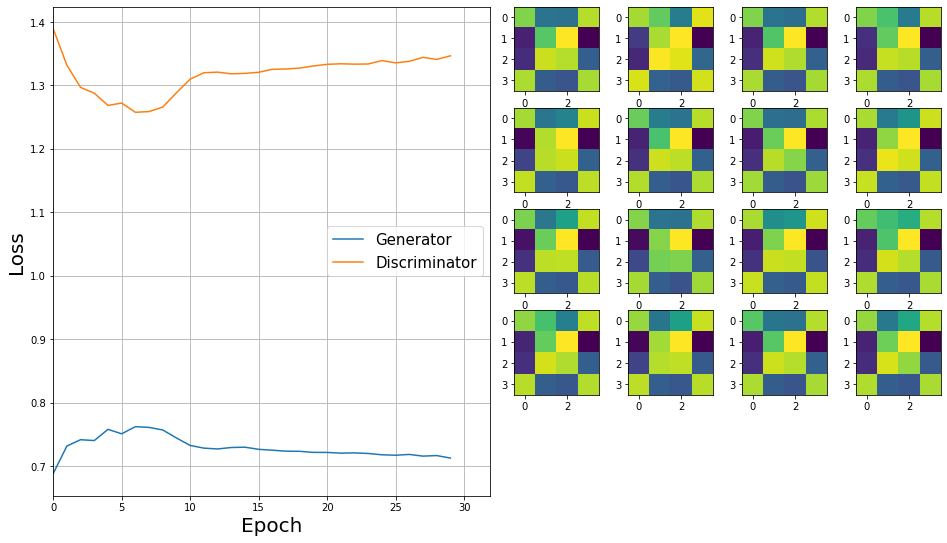

In [18]:
qgan.train(x_class_1[:200])

Check out the images generated by the generator

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

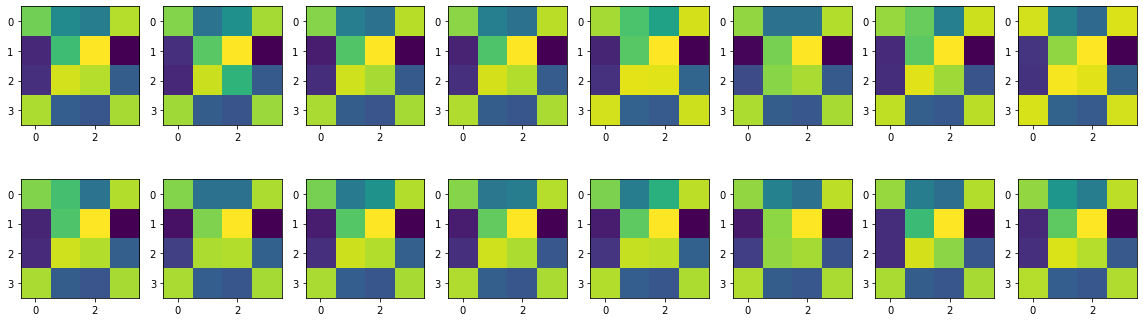

In [19]:
x_gen = qgan.generate_samples(batch_size=16)
visualize_images(x_gen)

### Studying the Model Outputs

- It is often helpful to study the output at various stages of the generator/discriminator especially for the QConv2D layers

In [20]:
qgan.G.layers

In [21]:
generator_conv_1 = qgan.G.layers[1]
generator_conv_2 = qgan.G.layers[2]

In [22]:
qgan.D.layers

In [23]:
discriminator_conv_1 = qgan.D.layers[0]
discriminator_conv_2 = qgan.D.layers[1]

In [24]:
# create prior samples for generator
tf.random.set_seed(0)
batch_size = 16
z = tf.random.normal((batch_size, 4, 4, 1), seed=0)

In [25]:
generator_output_conv_1 = generator_conv_1(z)

In [26]:
generator_output_conv_1.shape

TensorShape([16, 4, 4, 2])

Output from the first quantum convolution layer for the generator (filter 1):


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

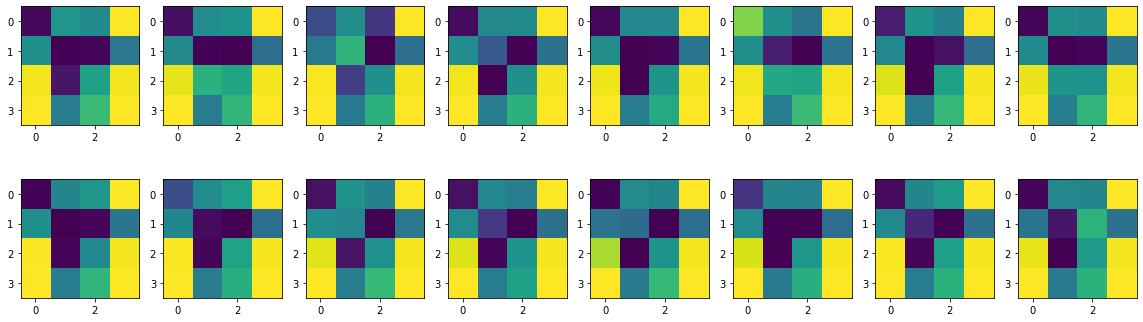

In [27]:
print("Output from the first quantum convolution layer for the generator (filter 1):")
visualize_images(generator_output_conv_1[:, :, :, 0])

Output from the first quantum convolution layer for the generator (filter 2):


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

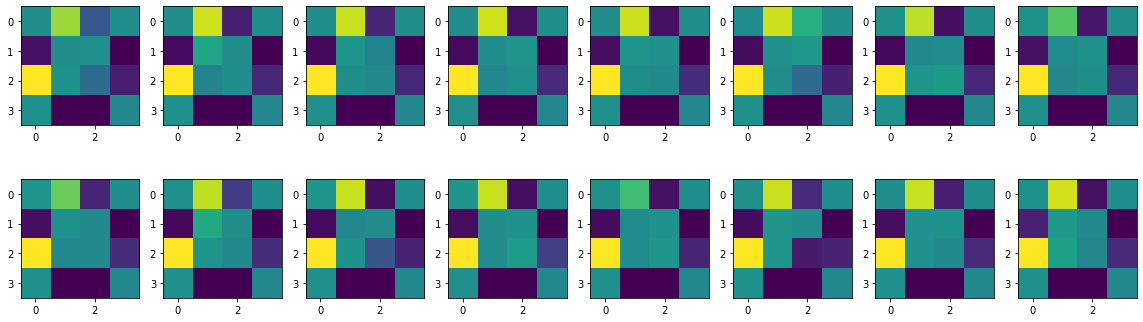

In [28]:
print("Output from the first quantum convolution layer for the generator (filter 2):")
visualize_images(generator_output_conv_1[:, :, :, 1])

In [29]:
generator_output_conv_2 = generator_conv_2(generator_output_conv_1)
generator_output_conv_2.shape

TensorShape([16, 4, 4, 1])

Output from the second quantum convolution layer for the generator:


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

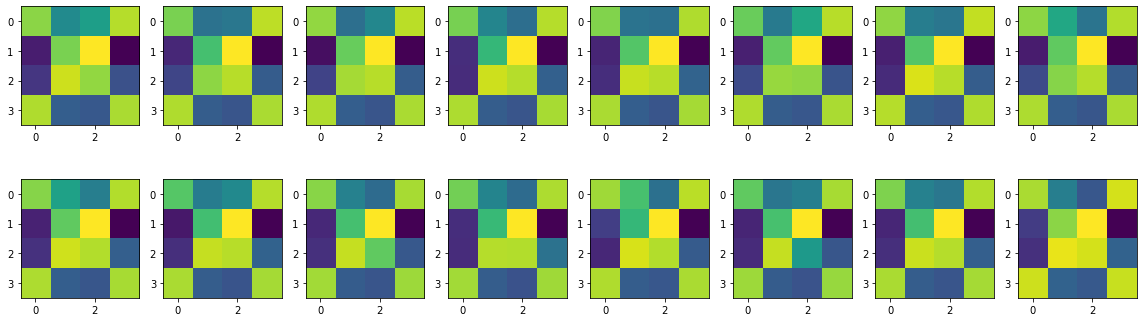

In [30]:
print("Output from the second quantum convolution layer for the generator:")
visualize_images(generator_output_conv_2[:, :, :, 0])

In [31]:
# use the real data for the discriminator input
discriminator_output_conv_1 = discriminator_conv_1(x_class_1[:16])

In [32]:
discriminator_output_conv_1.shape

TensorShape([16, 4, 4, 3])

Output from the first quantum convolution layer for the discriminator (filter 1):


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

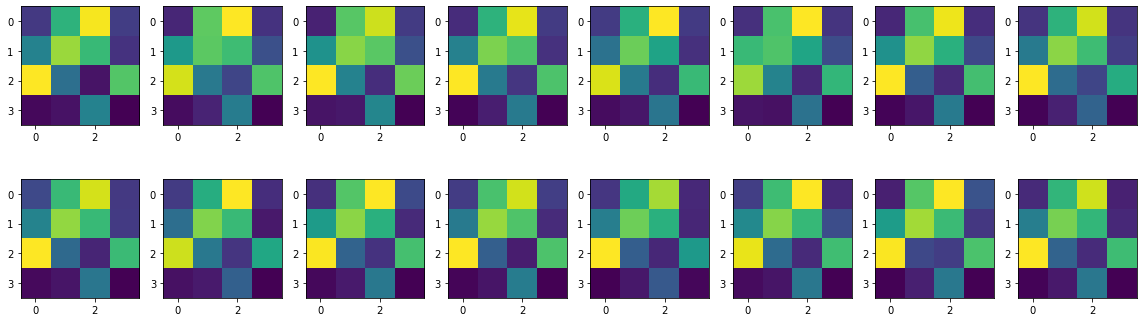

In [33]:
print("Output from the first quantum convolution layer for the discriminator (filter 1):")
visualize_images(discriminator_output_conv_1[:, :, :, 0])

Output from the first quantum convolution layer for the discriminator (filter 2):


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

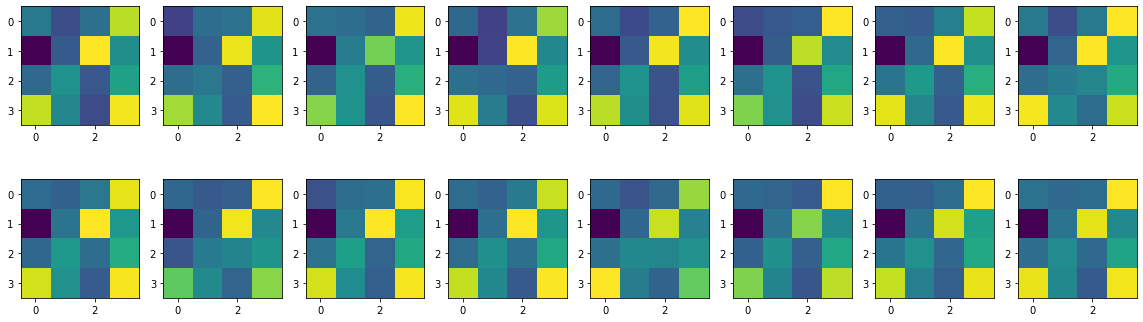

In [34]:
print("Output from the first quantum convolution layer for the discriminator (filter 2):")
visualize_images(discriminator_output_conv_1[:, :, :, 1])

Output from the first quantum convolution layer for the discriminator (filter 3):


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

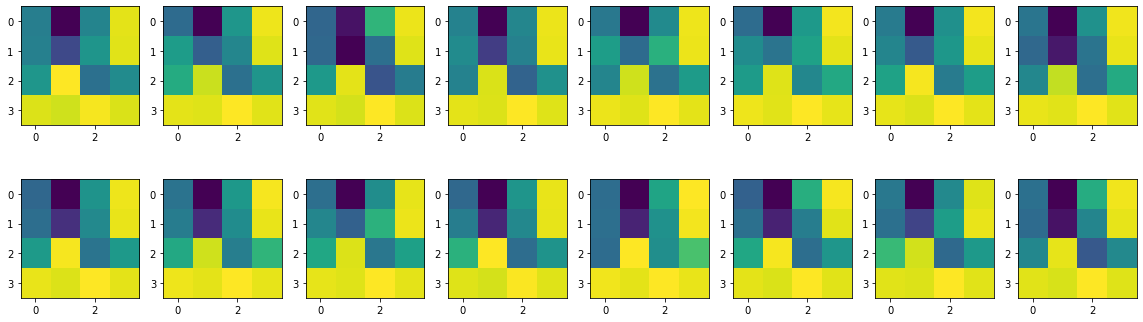

In [35]:
print("Output from the first quantum convolution layer for the discriminator (filter 3):")
visualize_images(discriminator_output_conv_1[:, :, :, 2])

In [36]:
discriminator_output_conv_2 = discriminator_conv_2(discriminator_output_conv_1)
discriminator_output_conv_2.shape

TensorShape([16, 2, 2, 1])

Output from the second quantum convolution layer for the discriminator:


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

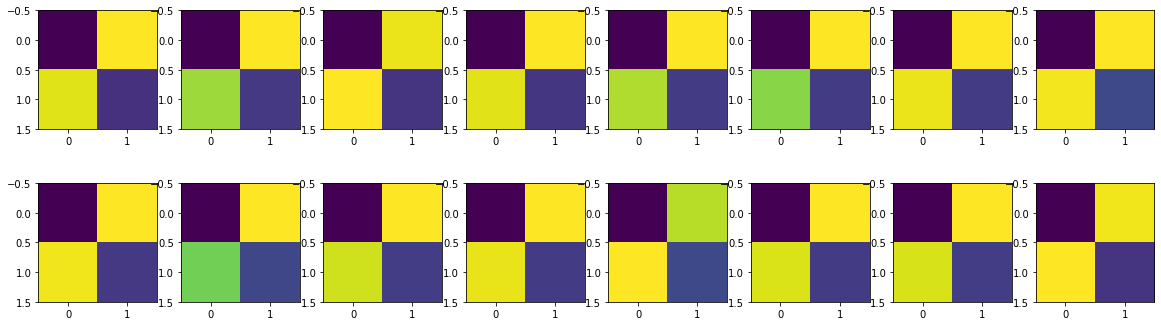

In [37]:
print("Output from the second quantum convolution layer for the discriminator:")
visualize_images(discriminator_output_conv_2[:, :, :, 0])

Output from the second quantum convolution layer for the discriminator (using noise as input):


<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

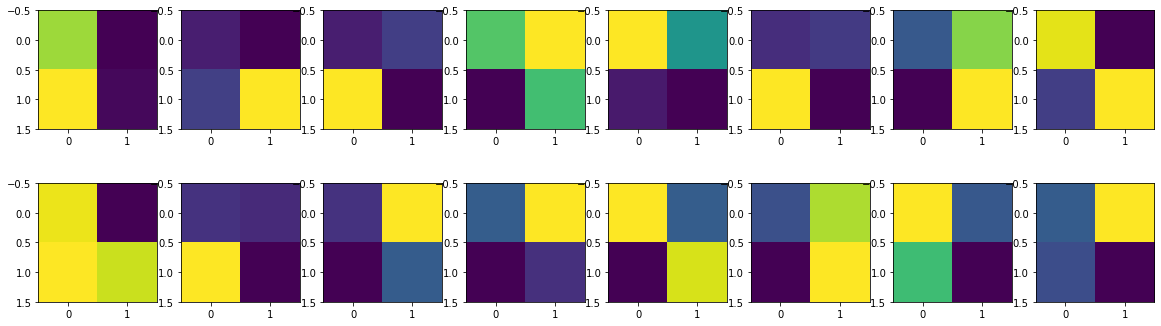

In [38]:
# now compared to using a random noise as input
discriminator_output_conv_1_noise = discriminator_conv_1(z)
discriminator_output_conv_2_noise = discriminator_conv_2(discriminator_output_conv_1_noise)
print("Output from the second quantum convolution layer for the discriminator (using noise as input):")
visualize_images(discriminator_output_conv_2_noise[:, :, :, 0])

We can definitely see a difference in the output pattern from a "true" input and "random" input!

### Checkpointing

- The `QGAN` class supports easy checkpointing by supplying the following arguments when instantiating the class:

  - `checkpoint_dir`: The path to a directory in which to write checkpoints. If None, no checkpoint will be saved.
  - `checkpoint_interval`: Number of epochs between each checkpoint. Default is 10.
  - `checkpoint_max_to_keep`: Number of checkpoints to keep. If None, all checkpoints are kept. Default is None.

In [39]:
# to checkout available checkpoints:
qgan.checkpoint_manager.checkpoints

['./training_checkpoints/QGAN/tutorial_image_4x4/ckpt-1',
 './training_checkpoints/QGAN/tutorial_image_4x4/ckpt-2',
 './training_checkpoints/QGAN/tutorial_image_4x4/ckpt-3']

In [40]:
# restore the first checkpoint
qgan.restore_checkpoint(qgan.checkpoint_manager.checkpoints[0])

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

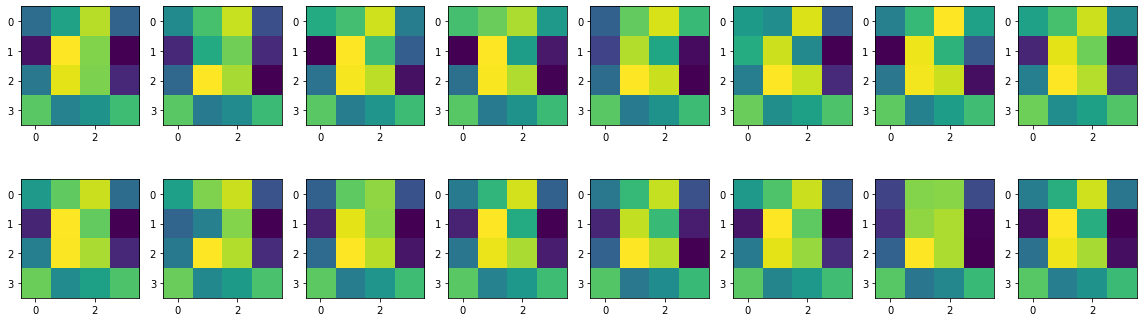

In [41]:
# checkout the generated images at this checkpoint
x_gen_ckpt_1 = qgan.generate_samples(batch_size=16)
visualize_images(x_gen_ckpt_1)

In [42]:
# restore the second checkpoint
qgan.restore_checkpoint(qgan.checkpoint_manager.checkpoints[1])

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

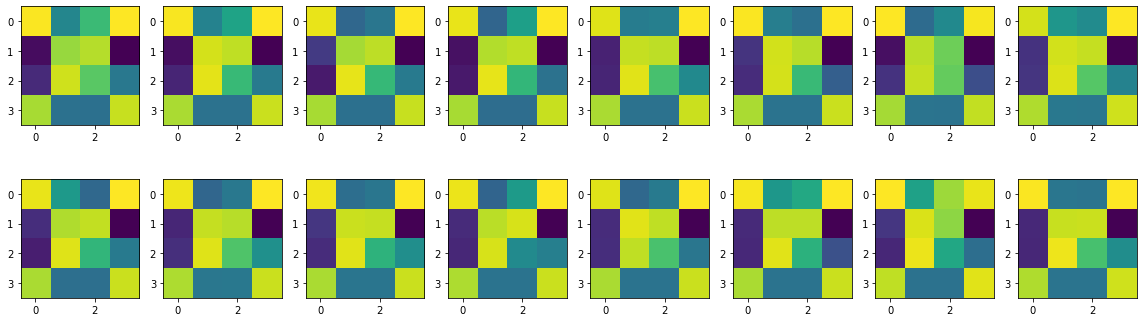

In [43]:
# checkout the generated images at this checkpoint
x_gen_ckpt_2 = qgan.generate_samples(batch_size=16)
visualize_images(x_gen_ckpt_2)

In [44]:
# restore the last checkpoint
qgan.restore_checkpoint()

<module 'matplotlib.pyplot' from '/afs/cern.ch/work/c/chlcheng/public/local/conda/miniconda/envs/ml-base/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

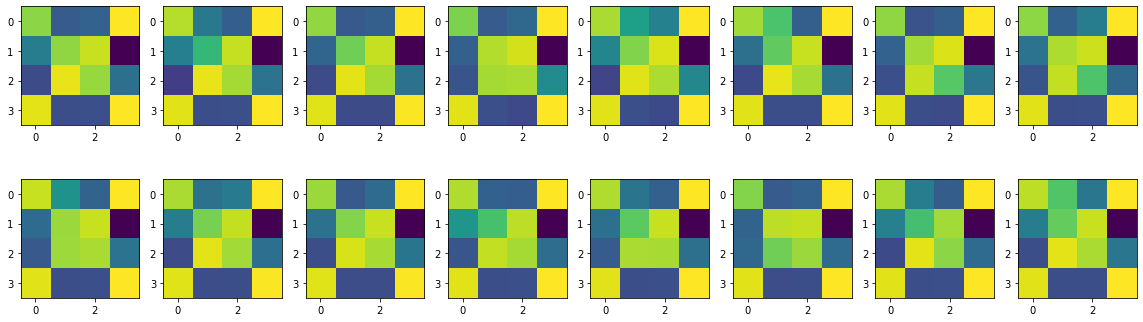

In [45]:
# checkout the generated images at this checkpoint
x_gen_latest_ckpt = qgan.generate_samples(batch_size=16)
visualize_images(x_gen_latest_ckpt)

## 4. Quantum Wasserstein GAN (QWGAN)

Some major shortcomings of the original GAN model are the mode-colapse and vanishing gradients. To circumvent these, the Wasserstein GAN is introduced by [Arjovsky](https://arxiv.org/pdf/1701.07875.pdf). Wasserstein GANs are less vulnerable to getting stuck than minimax-based GANs, and avoid problems with vanishing gradients.

The key differences between the original GAN and the Wasserstein GANs are:

1. Use of Wasserstein distance (Earth mover's distance) instead of the minimax loss function
2. Use of critics instead of discriminator (functionally the same as discriminator) and allows multiple discriminator iterations per generator iteration
3. Use of the RMSprop optimizer instead of the Adam optimizer
4. Use of weight clipping so that weights throughout the GAN remain within a constrained range.

The 4-th requirement is not necessary for a purely quantum Wasserstein GAN model since PQC weights are already bounded in the range $[-\pi, \pi]$ or $[0, 2\pi]$.

The `QWGAN` class from Quple inherits from the `QGAN` class with the only difference between the replacement of the modified minimax loss function by the **Wasserstein loss function**.

Both `QGAN` and `QWGAN` classes support multiple discriminator iterations per generator iteration via the `n_disc` argument. Users can also choose different optimizers via the `optimizer` argument. 

We build the QWGAN model with the following setup:

- Number of epochs: 20
- Generator optimizer: Adam (learning rate = 0.01)
- Discriminator optimizer: Adam (learning rate = 0.01)
- Batch size: 16
- Number of discriminator iteration per generator iteration in each epoch: 3

Note: The Adam optimizer is used because it converge faster than the RMSprop optimizer for the examples used in this tutorial. 

In [46]:
from quple.models.generative import QWGAN

In [47]:
optimizer_kwargs = {
    "generator": {"learning_rate": 1e-2},
    "discriminator": {"learning_rate": 1e-2}
}
generator = create_quantum_generator()
#discriminator = create_classical_discriminator()
discriminator = create_quantum_discriminator()
qwgan = QWGAN(generator, discriminator,
            epochs=20, batch_size=16,
            n_disc=3,
            optimizer="adam",
            optimizer_kwargs=optimizer_kwargs,
            random_state=2021, 
            checkpoint_dir="./training_checkpoints/QWGAN/tutorial_image_4x4")
qwgan.enable_visualization((4, 4), n_image=16)

Summary of Generator
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 4, 4, 1)           0         
_________________________________________________________________
q_conv2d_4 (QConv2D)         (None, 4, 4, 2)           1728      
_________________________________________________________________
q_conv2d_5 (QConv2D)         (None, 4, 4, 1)           32        
Total params: 1,760
Trainable params: 1,760
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
q_conv2d_6 (QConv2D)         (None, 4, 4, 3)           48        
_________________________________________________________________
q_conv2d_7 (QConv2D)         (None, 2, 2, 1)      

We will use a sample size of 1000 for training.

Note: More samples is used because the true batchsize is `n_disc*batch_size` and each discriminator iteration uses one batch of data. 

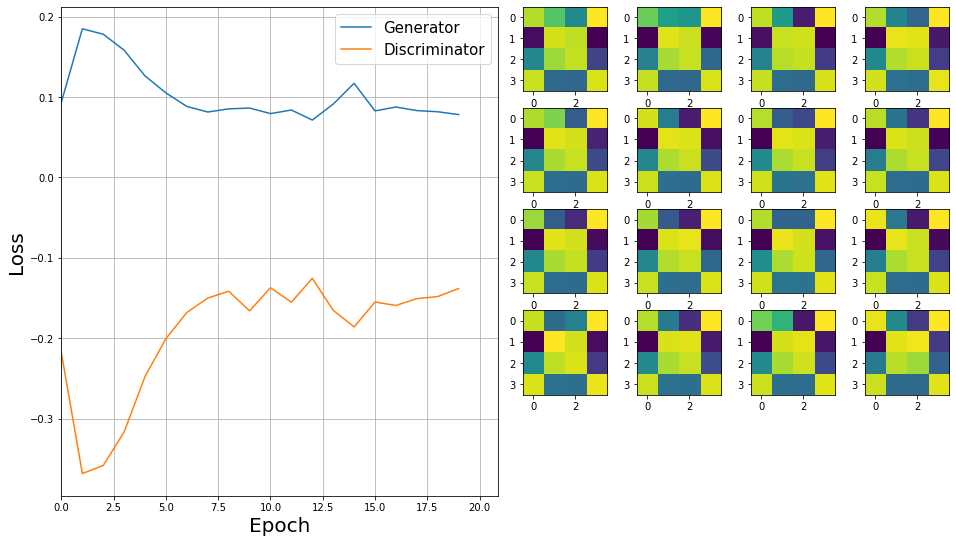

In [48]:
qwgan.train(x_class_1[:1000])

### Extra: Try out the second image class

In [50]:
optimizer_kwargs = {
    "generator": {"learning_rate": 1e-2},
    "discriminator": {"learning_rate": 1e-2}
}
generator = create_quantum_generator()
discriminator = create_quantum_discriminator()
qgan2 = QWGAN(generator, discriminator,
              epochs=50, batch_size=16,
              n_disc=3,
              optimizer="adam",
              optimizer_kwargs=optimizer_kwargs,
              random_state=2021, 
              checkpoint_dir="./training_checkpoints/QWGAN/tutorial_image2_4x4")
qgan2.enable_visualization((4, 4), n_image=16)

Summary of Generator
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 4, 4, 1)           0         
_________________________________________________________________
q_conv2d_12 (QConv2D)        (None, 4, 4, 2)           1728      
_________________________________________________________________
q_conv2d_13 (QConv2D)        (None, 4, 4, 1)           32        
Total params: 1,760
Trainable params: 1,760
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
q_conv2d_14 (QConv2D)        (None, 4, 4, 3)           48        
_________________________________________________________________
q_conv2d_15 (QConv2D)        (None, 2, 2, 1)      

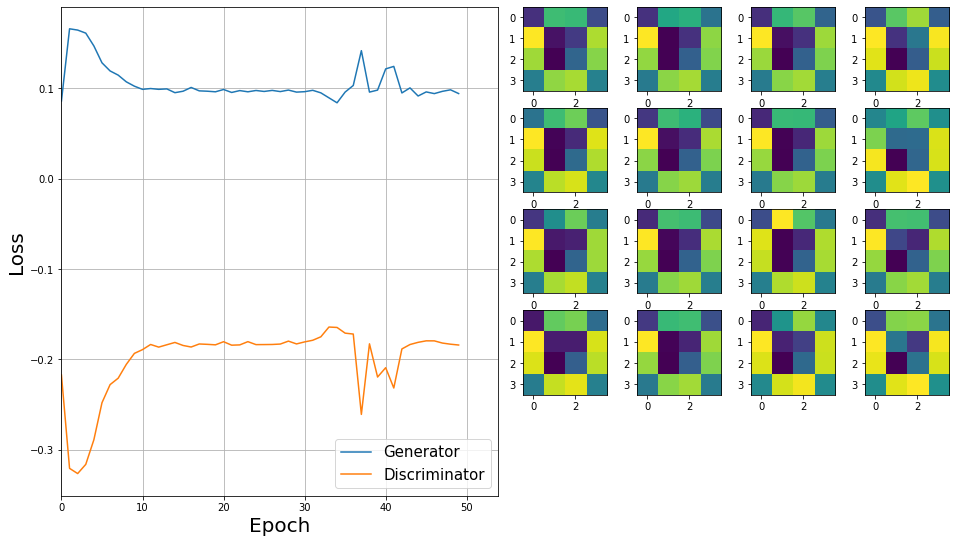

In [51]:
qgan2.train(x_class_2[:1000])

Turns out the second image class is a little harder to train with the same architecture.